# Advanced Regression

[See Problem Description & Data on Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

> Goal: Predict housing prices

> Method: Ensemble learning outperforms baseline models

# I) Setup and imports

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.gridspec as gridspec
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

In [349]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**train dataset**: 1460 rows x 81 cols

**test dataset**: 1459 rows x 80 cols (no target)

# II) EDA: Data observations

In [382]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

Most of the features are objects

In [383]:
def missing_percentage(df):
    """
    :param df: takes a DataFrame(df) as input 
    
    returns two columns, total missing values and total missing values percentage"""
 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().
                                                             sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

print('Number of features with missing value in training data:', missing_percentage(train).shape[0]) #print total train

Number of features with missing value in training data: 19


In [384]:
print('Number of features with missing value in test data:', missing_percentage(test).shape[0]) #print total test

Number of features with missing value in test data: 33


Test dataset has more features with missing values

In [ ]:
sns.set_palette("GnBu_d")

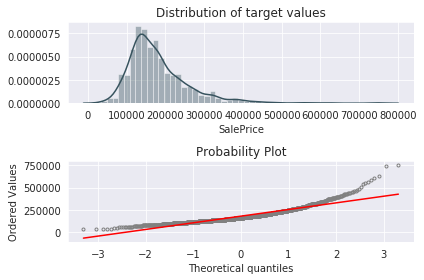

In [385]:
# check whether target variable, SalePrice, is normally distributed
sns.set_style('darkgrid')

fig, (ax1,ax2) = plt.subplots(2,1) 
ax1 = sns.distplot(train.loc[:,'SalePrice'], norm_hist=True, ax = ax1)
ax1.set_title('Distribution of target values')
s = stats.probplot(train.loc[:,'SalePrice'], plot = ax2)
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_fillstyle('none')#markerfacecolor('none')
ax2.get_lines()[0].set_markeredgecolor('gray')
plt.tight_layout()
None

In [386]:
print("Skewness: " + str(train['SalePrice'].skew()))
print("Kurtosis: " + str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


Target varaible is right-skewed (positive skew), and there are outliers. Will need to be addressed with transformations later on.

In [387]:
## Getting the correlation of all the features with target variable. See first 10
(train.corr())["SalePrice"].sort_values(ascending = False)[1:][0:10]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

`OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF`,`1stFlrSF`,`FullBath`, `TotRmsAbvGrd`,`YearBuilt`,and `YearRemodAdd` all have correlation with target >0.5

Check a few of these feature distributions (ex 4 most correlated) for variance, whether there's outliers... 

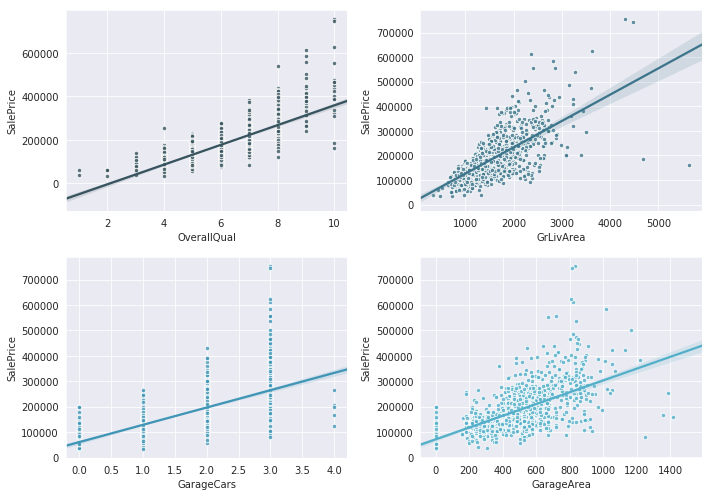

In [388]:
fig, (axs) = plt.subplots(2,2, figsize=(10,7))
#sns.scatterplot(train.OverallQual, train.SalePrice, ax=axs[0,0])
sns.regplot(x=train.OverallQual, y=train.SalePrice, ax=axs[0,0], scatter_kws={"s": 20, "edgecolor":'white'})

#sns.scatterplot(train.GrLivArea, train.SalePrice, ax=axs[0,1])
sns.regplot(x=train.GrLivArea, y=train.SalePrice, ax=axs[0,1], scatter_kws={"s": 20,"edgecolor":'white'})

#sns.scatterplot(train.GarageCars, train.SalePrice, ax=axs[1,0])
sns.regplot(x=train.GarageCars, y=train.SalePrice, ax=axs[1,0], scatter_kws={"s": 20,"edgecolor":'white'})

#sns.scatterplot(train.GarageArea, train.SalePrice, ax=axs[1,1])
sns.regplot(x=train.GarageArea, y=train.SalePrice, ax=axs[1,1], scatter_kws={"s": 20,"edgecolor":'white'})
plt.tight_layout()
None

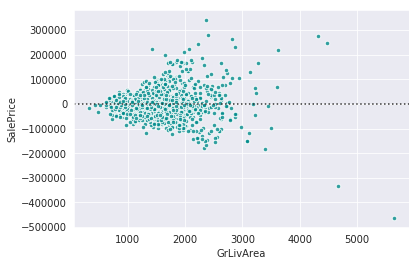

In [389]:
sns.residplot(train.GrLivArea, train.SalePrice, color='darkcyan',scatter_kws={"s": 20,"edgecolor":'white'});

Variability in target variable increases as the value of the features increases, not equal variance. Outliers.

# III) Feature engineering

## 1- transform target data

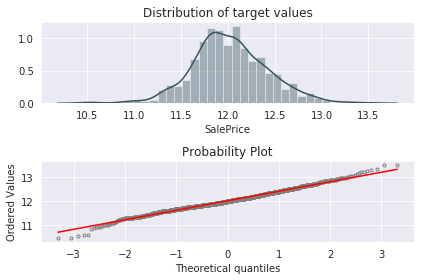

In [390]:
## trainsforming target variable taking natural log(1+x)
train["SalePrice"] = np.log1p(train["SalePrice"])

fig, (ax1,ax2) = plt.subplots(2,1) 
ax1 = sns.distplot(train.loc[:,'SalePrice'], norm_hist=True, ax = ax1)
ax1.set_title('Distribution of target values')
s = stats.probplot(train.loc[:,'SalePrice'], plot = ax2)
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_fillstyle('none')#markerfacecolor('none')
ax2.get_lines()[0].set_markeredgecolor('gray')
plt.tight_layout()
None

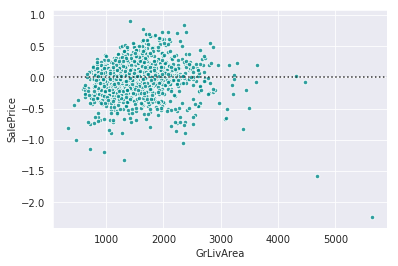

In [391]:
sns.residplot(train.GrLivArea, train.SalePrice, color='darkcyan',scatter_kws={"s": 20,"edgecolor":'white'});

Transforming the target variable helped with the constant variability issue we were seeing before in other features. Now, almost equal variance.

## 2- check for multicollinearity

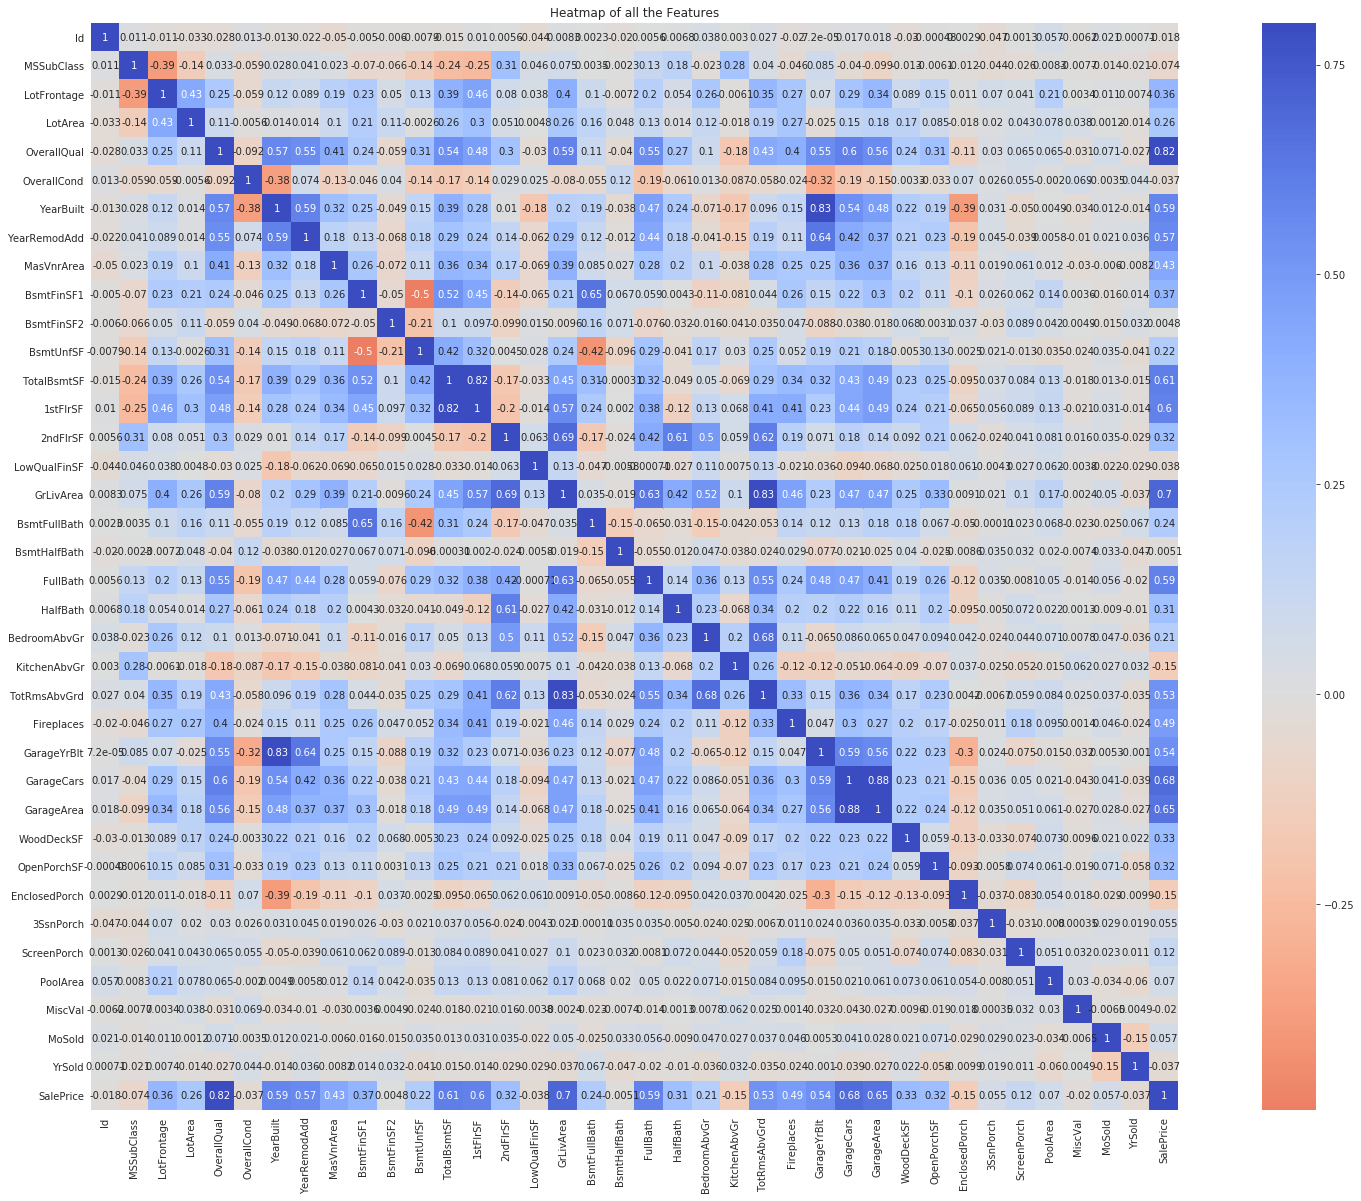

In [392]:
plt.subplots(figsize = (30,20))
sns.heatmap(train.corr(), vmax=0.8, square=True, annot=True, center = 0, cmap='coolwarm_r');
plt.title("Heatmap of all the Features");

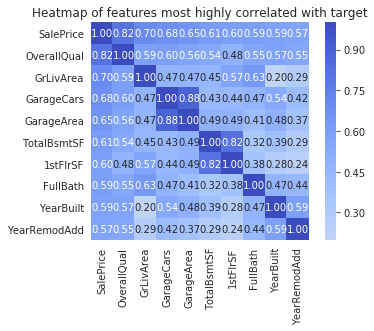

In [393]:
k = 10 #number of variables for heatmap
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', cmap='coolwarm_r', center=0, annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Heatmap of features most highly correlated with target')
plt.show()

Linear regression requires independent variables to have little or no similar features, so avoid multicollinearity. Since our data does have some level of correlation between certain features, will have to introduce regularization in model to take care of that.

## 3- Handle missing data

In [395]:
# transformations have to be done on both training and test data
all_data = pd.concat((train, test), sort=False).reset_index(drop = True)

## Dropping the target variable
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [396]:
# some features should be categorical instead of num
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# fill missing with mode, 
# usually, avoid data leakage by taking mode of training only, but here the missing value
# is in test data, so take mode of test? would keep two datasets separate
# group_by & transform -> split data into groups based on some criteria, and apply a function to each 
# group independently
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


For missing values, usually consider that when more than 15% of data is missing we should delete the corresponding variable. In this case, could pull more from data descriptions though (ex PoolQC with Na means no pool).

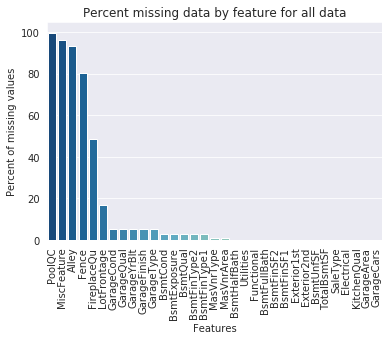

In [397]:
plt.xticks(rotation='90')
sns.barplot(x=missing_percentage(all_data).index, y=missing_percentage(all_data)['Percent'], palette='GnBu_r')
plt.xlabel('Features')
plt.ylabel('Percent of missing values')
plt.title('Percent missing data by feature for all data')
None

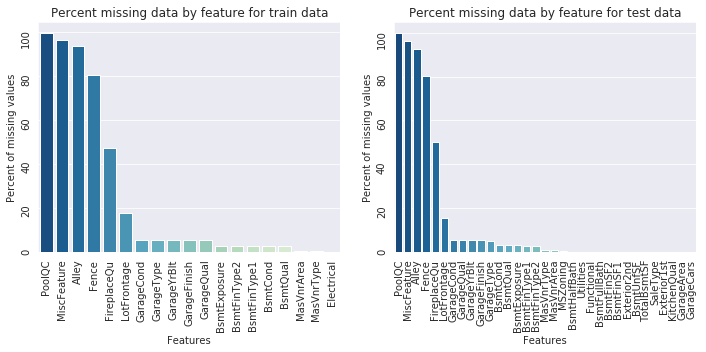

In [398]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

sns.barplot(x=missing_percentage(train).index, y=missing_percentage(train)['Percent'], ax=axs[0], palette='GnBu_r')
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Percent of missing values')
axs[0].set_title('Percent missing data by feature for train data')
axs[0].tick_params(rotation=90)

sns.barplot(x=missing_percentage(test).index, y=missing_percentage(test)['Percent'], ax=axs[1], palette='GnBu_r')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Percent of missing values')
plt.title('Percent missing data by feature for test data')
axs[1].tick_params(rotation=90)

plt.tight_layout()
None

In [399]:
# fill with None
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None") # no alley access
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
# hestitant about using median of full dataset...

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

# fill with relevant corresponding data
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 

# fill with mode
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(test['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(test['SaleType'].mode()[0])

In [400]:
missing_percentage(all_data)

,Total,Percent


All missing data has been handled.

In [401]:
all_data.shape

(2919, 80)

## 4- Transform highly skewed features

In [402]:
# some features are also skewed, let's see the top 10 most skewed and their values

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_feats[:10]

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
dtype: float64

skew:  1.4696044169256821


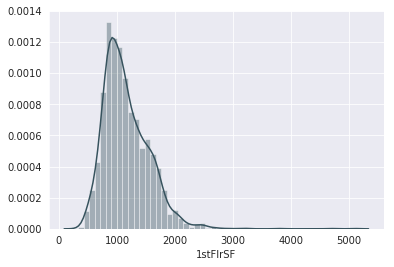

In [403]:
sns.distplot(all_data['1stFlrSF']);
print('skew: ', skewed_feats['1stFlrSF'])

In [404]:
# use Box-Cox transformation for highly skewed features
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
    
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
skewed_features = high_skew.index

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], boxcox_normmax(all_data[feat] + 1))

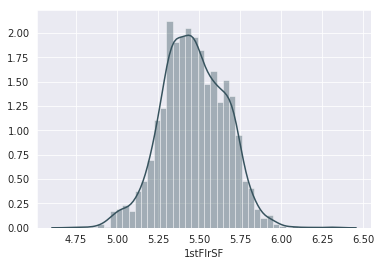

In [405]:
sns.distplot(all_data['1stFlrSF']);

transformed to normality!

## 5- Feature generation

In [406]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# and total porch sq as well as total bathrooms
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

In [407]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [408]:
all_data.shape
# added 8 new features

(2919, 88)

## 5- Encode categorical data

In [409]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [410]:
# for encoding categorical values, there are a few that do have information in ordering (ordinal)
# so try label encoder
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'OverallCond', 'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [411]:
all_data['CentralAir'].unique()

array(['Y', 'N'], dtype=object)

In [412]:
all_data.dtypes.value_counts()

object     31
float64    31
int64      26
dtype: int64

In [413]:
# for the other 31 objects, apply one hot encoding
all_data = pd.get_dummies(all_data, drop_first=True).reset_index(drop=True)

In [414]:
all_data.dtypes.value_counts()

uint8      180
float64     31
int64       26
dtype: int64

## 6- Handle outliers

In [415]:
# to remove outliers, use winsorization - floor and ceiling applied to outliers (replaces values)
wins_data = stats.mstats.winsorize(all_data, limits=[0.05, 0.05])
wins_data = pd.DataFrame(wins_data, columns=all_data.columns)
wins_data.head(5)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,13.770815,13.424520,7.0,4.0,13.770815,13.770815,13.770815,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2.0,13.770815,13.694527,6.0,7.0,13.770815,13.770815,0.000000,3.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3.0,13.770815,13.770815,7.0,4.0,13.770815,13.770815,13.770815,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4.0,13.770815,13.683421,7.0,4.0,13.770815,13.770815,0.000000,3.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5.0,13.770815,13.770815,8.0,4.0,13.770815,13.770815,13.770815,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 7- retrieve train and test data

In [416]:
ntrain = train.shape[0]

X = all_data[:ntrain]
y = train['SalePrice']

X_predict = all_data[ntrain:]

In [417]:
X_predict.shape # for submission

(1459, 237)

# IV) Training

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 0)

In [418]:
X_train.shape, X_test.shape

((1022, 237), (438, 237))

## Evaluation metric

In [ ]:
# Root mean squared (RMSE) using cross validation
folds = 10

def rmse_cv(model):
    """ ex with model=LinearRegression()"""
    cv = KFold(shuffle=True, random_state=2, n_splits=folds)
    scores = cross_val_score(model, X,y,cv = cv, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-scores)
    
    return rmse

## Baseline models

Due to collinearity, we know we have to introduce regularization (Lasso/Ridge/ENet). Try SVR & other tree-based models as well:
* **Ridge Regression**
* **Lasso Regression**
* **ElasticNet Regression**
* **Support Vector Regression**
* **Gradient Boosted Regressor** - ensemble of weak predicition models, boost -> train on residuals from error of previous model
* **LightGBM**
* **XGBoost** - fast implementation, even more resistant to outliers

For info on light GBM and tuning hyperparams, see https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Explore what range of hyperparams give best scores with CV

#alpha_grid = [8., 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9]
#l1_ratio_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#comb = [(a,b) for a in alpha_grid for b in l1_ratio_grid]

#from sklearn.linear_model import Ridge

#results = {}
#for candidate_alpha in alpha_grid:
#for c in comb:
    #ridge_regression = Ridge(alpha=candidate_alpha)
    #validation_score = rmse_cv(ridge_regression)
    #results[candidate_alpha] = validation_score
    #results['{}_{}'.format(c[0], c[1])] = validation_score


#f = lambda x: np.mean(x)
#avg_results = {k: f(v) for k, v in results.items()}

#avg_results

In [ ]:
#min(avg_results, key=avg_results.get)

In [ ]:
# easier, more streamlined way of instantiating a model object with CV and search hyperparams
# RobustScaler() : Scale features using statistics that are robust to outliers

kfolds = KFold(n_splits=folds, shuffle=True, random_state=42)

alpha_grid = [8., 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9] #Ridge
alpha_grid2 = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001] #Lasso
alpha_grid3 = [0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.05] #ENet
l1_ratio_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty.

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alpha_grid, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alpha_grid2, cv=kfolds, max_iter=1e7))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=alpha_grid3, cv=kfolds, 
                                                        max_iter=1e7, l1_ratio=l1_ratio_grid))

In [ ]:
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state=42)
# huber loss helps with outlier robustness

In [ ]:
lightgbm = LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.01, n_estimators=5000,
                         max_bin=200, bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
                         feature_fraction=0.2, feature_fraction_seed=7, verbose=-1,)

In [ ]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460, max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7, colsample_bytree=0.7, objective='reg:linear', 
                       nthread=-1, scale_pos_weight=1, seed=27, reg_alpha=0.00006)

In [ ]:
# without cv, calcula
def rmse(model, X, y):
    return np.sqrt(-cross_val_score(model, X, y, cv = kfolds, scoring = 'neg_mean_squared_error'))

In [419]:
lasso_score = rmse(lasso, X, y)
ridge_score = rmse(ridge, X, y)
enet_score = rmse(elasticnet, X, y)
svr_score = rmse(svr, X, y)

In [420]:
# extract avg & std across all cross validated folds

print('Lasso: mean {:.4f}, std {:.4f}'.format(np.mean(lasso_score), np.std(lasso_score)))
print('Ridge: mean {:.4f}, std {:.4f}'.format(np.mean(ridge_score), np.std(ridge_score)))
print('ElasticNet: mean {:.4f}, std {:.4f}'.format(np.mean(enet_score), np.std(enet_score)))
print('SVR: mean {:.4f}, std {:.4f}'.format(np.mean(svr_score), np.std(svr_score)))

Lasso: mean 0.1279, std 0.0295
Ridge: mean 0.1290, std 0.0287
ElasticNet: mean 0.1277, std 0.0294
SVR: mean 0.1257, std 0.0361


In [ ]:
lightgbm_score = rmse(lightgbm, X, y)
xgboost_score = rmse(xgboost,X, y)

In [421]:
# extract avg across all cross validated folds

print('LightGBM: mean {:.4f}, std {:.4f}'.format(np.mean(lightgbm_score), np.std(lightgbm_score)))
print('XGBoost: mean {:.4f}, std {:.4f}'.format(np.mean(xgboost_score), np.std(xgboost_score)))

LightGBM: mean 0.1199, std 0.0188
XGBoost: mean 0.1214, std 0.0208


In [ ]:
X.dtypes.value_counts()

In [ ]:
# GBR can't handle too large values now (ex float32, even float16), so have to convert
X_int = X.astype(np.int64)
y_int = y.astype(np.int64)
gbr_score = rmse(gbr, X_int, y_int)

In [422]:
print('GBR: mean {:.4f}, std {:.4f}'.format(np.mean(gbr_score), np.std(gbr_score)))

GBR: mean 0.2805, std 0.0267


Try stacking models, with meta learner xgboost

In [ ]:
stack = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, svr, xgboost, lightgbm),
                            meta_regressor=xgboost,
                            use_features_in_secondary=True)

In [ ]:
stack_score = rmse(stack, np.array(X), np.array(y))

In [ ]:
print('Stacked: mean {:.4f}, std {:.4f}'.format(np.mean(stack_score), np.std(stack_score)))

In [ ]:
df_scores = pd.DataFrame([lasso_score, ridge_score, enet_score, svr_score, gbr_score, 
                          lightgbm_score, xgboost_score, stack_score],
                          index=['lasso', 'ridge', 'enet', 'svr', 'gbr', 'lightbgm', 
                                 'xgb', 'stacked'])#.transpose()
mean_df = df_scores.mean(axis=1)
std_df = df_scores.std(axis=1)

mean_df.head(10)

In [ ]:
g = sns.scatterplot(x=np.arange(8), y=mean_df, s=40, label='mean score')
plt.fill_between(np.arange(8), mean_df-std_df, mean_df+std_df, color='grey', alpha=0.2, label='+/- std')
plt.legend()
plt.ylabel('score')
g.set(xticklabels=['0','lasso', 'ridge', 'enet', 'svr', 'gbr', 'lightbgm', 'xgb', 'stacked']);

In [ ]:
df_scores = df_scores.drop('gbr')
mean_df = df_scores.mean(axis=1)

In [ ]:
g = sns.scatterplot(x=np.arange(7), y=mean_df, s=40)
plt.ylabel('score')
g.set(xticklabels=['0','lasso', 'ridge', 'enet', 'svr', 'lightbgm', 'xgb', 'stacked']);

## Start training

In [ ]:
print('Training Lasso model')
lasso_model = lasso.fit(X_train,y_train)

print('Training Ridge model')
ridge_model = ridge.fit(X_train,y_train)

print('Training ENet model')
enet_model = elasticnet.fit(X_train,y_train)

print('Training SVR model')
svr_model = svr.fit(X_train,y_train)

print('Training XGBoost model')
xgb_model = xgboost.fit(X_train,y_train)

print('Training LightGBM model')
lgb_model = lightgbm.fit(X_train,y_train)

print('Training Stacked model')
stack_model = stack.fit(np.array(X_train), np.array(y_train))

In [ ]:
def rmse_pred(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [358]:
# try predicting training data 

print('lasso rmse: {:.4f}'.format(rmse_pred(y_train, lasso_model.predict(X_train))))
print('ridge rmse: {:.4f}'.format(rmse_pred(y_train, ridge_model.predict(X_train))))
print('enet rmse: {:.4f}'.format(rmse_pred(y_train, enet_model.predict(X_train))))
print('svr rmse: {:.4f}'.format(rmse_pred(y_train, svr_model.predict(X_train))))
print('lightgbm rmse: {:.4f}'.format(rmse_pred(y_train, lgb_model.predict(X_train))))
print('xgb rmse: {:.4f}'.format(rmse_pred(y_train, xgb_model.predict(X_train))))
print('stacked rmse: {:.4f}'.format(rmse_pred(y_train, stack_model.predict(np.array(X_train)))))

lasso rmse: 0.0920
ridge rmse: 0.1018
enet rmse: 0.0925
svr rmse: 0.1051
lightgbm rmse: 0.0627
xgb rmse: 0.0426
stacked rmse: 0.0441


In [357]:
lasso_train_pred = lasso_model.predict(X_train)
ridge_train_pred = ridge_model.predict(X_train)
enet_train_pred = enet_model.predict(X_train)
svr_train_pred = svr_model.predict(X_train)
lgb_train_pred = lgb_model.predict(X_train)
xgb_train_pred = xgb_model.predict(X_train)
stack_train_pred = stack_model.predict(np.array(X_train))

After training on (training) data, **XGBoost** performs best, closely followed by the **Stacked** model.

In [359]:
# validate with test data

print('lasso rmse: {:.4f}'.format(rmse_pred(y_test, lasso_model.predict(X_test))))
print('ridge rmse: {:.4f}'.format(rmse_pred(y_test, ridge_model.predict(X_test))))
print('enet rmse: {:.4f}'.format(rmse_pred(y_test, enet_model.predict(X_test))))
print('svr rmse: {:.4f}'.format(rmse_pred(y_test, svr_model.predict(X_test))))
print('lightgbm rmse: {:.4f}'.format(rmse_pred(y_test, lgb_model.predict(X_test))))
print('xgb rmse: {:.4f}'.format(rmse_pred(y_test, xgb_model.predict(X_test))))
print('stacked rmse: {:.4f}'.format(rmse_pred(y_test, stack_model.predict(np.array(X_test)))))

lasso rmse: 0.1604
ridge rmse: 0.1456
enet rmse: 0.1568
svr rmse: 0.1479
lightgbm rmse: 0.1194
xgb rmse: 0.1199
stacked rmse: 0.1290


Generalizes reasonably well to unseen data.

### Try blending

In [361]:
def blend_predict_train(lasso_w, ridge_w, enet_w, svr_w, lgb_w, xgb_w, stack_w):
    """"Calculates predicted targets from training data as blend of baseline models,
    each baseline model's prediction is weighted by its corresponding weight"""
    blend_prediction = lasso_w * lasso_train_pred + \
                        ridge_w * ridge_train_pred + \
                        enet_w * enet_train_pred + \
                        svr_w * svr_train_pred + \
                        lgb_w * lgb_train_pred + \
                        xgb_w * xgb_train_pred +  \
                        stack_w * stack_train_pred
    
    return blend_prediction

In [368]:
# find weights through grid search that minimizes rmse on training data

from sklearn.model_selection  import ParameterGrid

grid_range = [0.05,0.1,0.15,0.2,0.25,0.3,0.35]
param_grid = {'lasso': grid_range, 'ridge': grid_range, 'enet': grid_range,
             'svr': grid_range, 'lgb': grid_range, 'xgb': grid_range, 'stack': grid_range}
grid = ParameterGrid(param_grid)
pred_score = []
sub_param_grid = [] 

for params in grid:
    if params['lasso']+params['ridge']+params['enet']+params['svr']+params['lgb']+params['xgb']+params['stack']==1:
        pred = blend_predict_train(params['lasso'],params['ridge'], params['enet'], params['svr'], 
                                params['lgb'], params['xgb'], params['stack'])
        pred_score.append(rmse_pred(y_train, pred))
        sub_param_grid.append({'lasso': params['lasso'], 'ridge': params['ridge'], 
                               'enet': params['enet'], 'svr': params['svr'], 
                               'lgb': params['lgb'], 'xgb': params['xgb'], 
                               'stack': params['stack']})
    

In [370]:
min_index = np.argmin(pred)
sub_param_grid[min_index]

{'lasso': 0.05,
 'ridge': 0.1,
 'enet': 0.05,
 'svr': 0.1,
 'lgb': 0.15,
 'xgb': 0.35,
 'stack': 0.2}

In [376]:
def blend_predict_X(lasso_w, ridge_w, enet_w, svr_w, lgb_w, xgb_w, stack_w, X):
    """"Calculates predicted targets from training data as blend of baseline models,
    each baseline model's prediction is weighted by its corresponding weight"""
    blend_prediction = lasso_w * lasso_model.predict(X) + \
                        ridge_w * ridge_model.predict(X) + \
                        enet_w * enet_model.predict(X) + \
                        svr_w * svr_model.predict(X) + \
                        lgb_w * lgb_model.predict(X) + \
                        xgb_w * xgb_model.predict(X) +  \
                        stack_w * stack_model.predict(np.array(X))
    
    return blend_prediction

In [377]:
blend_predict = blend_predict_X(0.05,0.1,0.05,0.1,0.15,0.35,0.2,X_train)

In [378]:
rmse_pred(y_train, blend_predict)

0.05619651742789181

In [371]:
blend_predict = 0.05 * lasso_model.predict(X_train) + \
                0.1 * ridge_model.predict(X_train) + \
                0.05 * enet_model.predict(X_train) + \
                0.1 * svr_model.predict(X_train) + \
                0.15 * lgb_model.predict(X_train) + \
                0.35 * xgb_model.predict(X_train) +  \
                0.2 * stack_model.predict(np.array(X_train)) 

In [379]:
# test data

blend_predict_test = blend_predict_X(0.05,0.1,0.05,0.1,0.15,0.35,0.2,X_test)

rmse_pred(y_test, blend_predict_test)

0.11929571300501372

Blending performs slightly better than XGBoost on unseen data (test).

## submission for test (unlabelled) data given to us

In [380]:
blend_predict_subm = blend_predict_X(0.05,0.1,0.05,0.1,0.15,0.35,0.2,X_predict)

In [381]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_predict_subm))

Predict submission
